In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import hmrf_gmm

# 1-D Example Data

## Create Model

In [2]:
phys_space = np.random.randn(500,1)
feat_space = np.random.randn(500,3)

np.random.seed(12345)
# define domain
latent_1D = np.zeros_like(phys_space[:,0])
dist = scipy.stats.bernoulli(0.01)

In [3]:
val = 0
for i in range(len(phys_space[:,0])):
    if dist.rvs():
        val = 1 - val
    latent_1D[i] = val

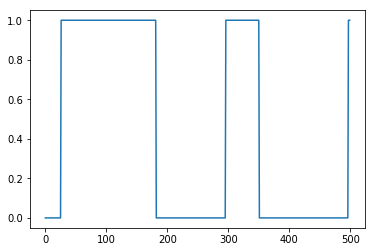

In [4]:
plt.plot(latent_1D);

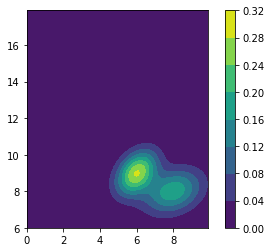

In [5]:
c1 = scipy.stats.multivariate_normal([6,9], [[0.5625, 0.225],[0.225, 0.675]])
c2 = scipy.stats.multivariate_normal([8,8], [[1.125, 0.225],[0.225, 0.675]])

x1, y1 = np.mgrid[-0:10:.1, 6:18:.1]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()

## Sample Data

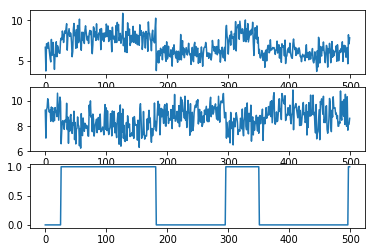

In [6]:
obs = np.empty((len(phys_space[:,0]), 2))
for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        obs[i,:] = c1.rvs()
    elif l == 1:
        obs[i,:] = c2.rvs()
        
fig, ax = plt.subplots(3,1)
ax[0].plot(obs[:,0])
ax[1].plot(obs[:,1])
ax[2].plot(latent_1D)

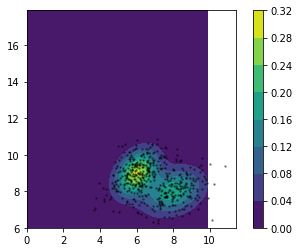

In [7]:
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()
plt.scatter(obs[:,0], obs[:,1], c='black', s=2, alpha=0.4)

## Try

In [8]:
ex1 = hmrf_gmm.HMRFGMM(phys_space, obs, beta_init=10)

In [15]:
mixprob = np.zeros((500,2))

In [17]:
ex1.fit(60)

  0%|                                                                                        | 0/60 [00:00<?, ?it/s]

beta prop: 4.26311551381
lmd_prev: -1206.98840825
lp_beta_prev: [[-5.52533204]]
lmd_prop: -1206.99155732
lp_beta_prop: [[-5.52575431]]
beta acc_ratio: [[ 0.99643503]]


  2%|█▎                                                                              | 1/60 [00:02<02:32,  2.59s/it]

beta prop: 4.48240500314
lmd_prev: -1207.34209794
lp_beta_prev: [[-5.52575431]]
lmd_prop: -1207.33834486
lp_beta_prop: [[-5.52563091]]
beta acc_ratio: [[ 1.003884]]


  3%|██▋                                                                             | 2/60 [00:05<02:29,  2.59s/it]

beta prop: 3.4691300454
lmd_prev: -1207.88785465
lp_beta_prev: [[-5.52563091]]
lmd_prop: -1207.93181028
lp_beta_prop: [[-5.52624133]]
beta acc_ratio: [[ 0.95641243]]


  5%|████                                                                            | 3/60 [00:07<02:30,  2.63s/it]

beta prop: 3.93893425953
lmd_prev: -1208.17095837
lp_beta_prev: [[-5.52624133]]
lmd_prop: -1208.14156732
lp_beta_prop: [[-5.52594555]]
beta acc_ratio: [[ 1.03013188]]


  7%|█████▎                                                                          | 4/60 [00:10<02:28,  2.66s/it]

beta prop: 3.92582515056
lmd_prev: -1208.6018214
lp_beta_prev: [[-5.52594555]]
lmd_prop: -1208.60239847
lp_beta_prop: [[-5.5259535]]
beta acc_ratio: [[ 0.99941515]]


  8%|██████▋                                                                         | 5/60 [00:13<02:25,  2.65s/it]

beta prop: 3.04121511935
lmd_prev: -1208.75676155
lp_beta_prev: [[-5.5259535]]
lmd_prop: -1208.90229226
lp_beta_prop: [[-5.52652995]]
beta acc_ratio: [[ 0.8640651]]


 10%|████████                                                                        | 6/60 [00:15<02:23,  2.65s/it]

beta prop: 3.19012360728
lmd_prev: -1210.20696132
lp_beta_prev: [[-5.52652995]]
lmd_prop: -1210.16377909
lp_beta_prop: [[-5.52642744]]
beta acc_ratio: [[ 1.04423519]]


 12%|█████████▎                                                                      | 7/60 [00:18<02:19,  2.64s/it]

beta prop: 2.74127273163
lmd_prev: -1209.71616543
lp_beta_prev: [[-5.52642744]]
lmd_prop: -1209.96171911
lp_beta_prop: [[-5.52674318]]
beta acc_ratio: [[ 0.78202434]]


 13%|██████████▋                                                                     | 8/60 [00:20<02:16,  2.62s/it]

beta prop: 3.53045127086
lmd_prev: -1211.10621729
lp_beta_prev: [[-5.52674318]]
lmd_prop: -1210.92711403
lp_beta_prop: [[-5.52620147]]
beta acc_ratio: [[ 1.19679238]]


 15%|████████████                                                                    | 9/60 [00:23<02:13,  2.62s/it]

beta prop: 3.33469829525
lmd_prev: -1211.69826701
lp_beta_prev: [[-5.52620147]]
lmd_prop: -1211.72463921
lp_beta_prop: [[-5.52633003]]
beta acc_ratio: [[ 0.9738473]]


 17%|█████████████▏                                                                 | 10/60 [00:26<02:10,  2.61s/it]

beta prop: 3.96973488207
lmd_prev: -1209.32700874
lp_beta_prev: [[-5.52633003]]
lmd_prop: -1209.25955627
lp_beta_prop: [[-5.52592692]]
beta acc_ratio: [[ 1.07021073]]


 18%|██████████████▍                                                                | 11/60 [00:28<02:08,  2.61s/it]

beta prop: 2.78640255174
lmd_prev: -1210.16638163
lp_beta_prev: [[-5.52592692]]
lmd_prop: -1210.49217127
lp_beta_prop: [[-5.52671052]]
beta acc_ratio: [[ 0.72139154]]


 20%|███████████████▊                                                               | 12/60 [00:31<02:05,  2.61s/it]

beta prop: 1.87894975344
lmd_prev: -1213.79236237
lp_beta_prev: [[-5.52671052]]
lmd_prop: -1217.81386234
lp_beta_prop: [[-5.52740629]]
beta acc_ratio: [[ 0.01791359]]


 22%|█████████████████                                                              | 13/60 [00:33<02:02,  2.60s/it]

beta prop: 3.86611153851
lmd_prev: -1216.20167103
lp_beta_prev: [[-5.52671052]]
lmd_prop: -1215.81549657
lp_beta_prop: [[-5.52598995]]
beta acc_ratio: [[ 1.47240192]]


 23%|██████████████████▍                                                            | 14/60 [00:36<01:59,  2.60s/it]

beta prop: 3.4222571668
lmd_prev: -1213.05685352
lp_beta_prev: [[-5.52598995]]
lmd_prop: -1213.12235285
lp_beta_prop: [[-5.52627205]]
beta acc_ratio: [[ 0.93633549]]


 25%|███████████████████▊                                                           | 15/60 [00:38<01:56,  2.59s/it]

beta prop: 1.80506524945
lmd_prev: -1211.65192108
lp_beta_prev: [[-5.52627205]]
lmd_prop: -1216.95852623
lp_beta_prop: [[-5.52746657]]
beta acc_ratio: [[ 0.00495281]]


 27%|█████████████████████                                                          | 16/60 [00:41<01:53,  2.59s/it]

beta prop: 1.82112810739
lmd_prev: -1214.47366925
lp_beta_prev: [[-5.52627205]]
lmd_prop: -1219.28060072
lp_beta_prop: [[-5.52745342]]
beta acc_ratio: [[ 0.00816325]]


 28%|██████████████████████▍                                                        | 17/60 [00:43<01:51,  2.58s/it]

beta prop: 2.82350696557
lmd_prev: -1214.24424913
lp_beta_prev: [[-5.52627205]]
lmd_prop: -1214.52145078
lp_beta_prop: [[-5.52668382]]
beta acc_ratio: [[ 0.75758963]]


 30%|███████████████████████▋                                                       | 18/60 [00:46<01:48,  2.58s/it]

beta prop: 4.96431645377
lmd_prev: -1216.74836685
lp_beta_prev: [[-5.52668382]]
lmd_prop: -1216.38089582
lp_beta_prop: [[-5.52537662]]
beta acc_ratio: [[ 1.44596689]]


 32%|█████████████████████████                                                      | 19/60 [00:49<01:45,  2.58s/it]

beta prop: 5.56781835001
lmd_prev: -1217.79490247
lp_beta_prev: [[-5.52537662]]
lmd_prop: -1217.78693459
lp_beta_prop: [[-5.52509093]]
beta acc_ratio: [[ 1.00828773]]


 33%|██████████████████████████▎                                                    | 20/60 [00:51<01:43,  2.58s/it]

beta prop: 5.04765822052
lmd_prev: -1216.86192807
lp_beta_prev: [[-5.52509093]]
lmd_prop: -1216.86772368
lp_beta_prop: [[-5.525335]]
beta acc_ratio: [[ 0.99397852]]


 35%|███████████████████████████▋                                                   | 21/60 [00:54<01:40,  2.58s/it]

beta prop: 6.08130131662
lmd_prev: -1216.7617141
lp_beta_prev: [[-5.525335]]
lmd_prop: -1216.75345185
lp_beta_prop: [[-5.52487653]]
beta acc_ratio: [[ 1.00875886]]


 37%|████████████████████████████▉                                                  | 22/60 [00:56<01:37,  2.57s/it]

beta prop: 6.15469217237
lmd_prev: -1214.00562564
lp_beta_prev: [[-5.52487653]]
lmd_prop: -1214.00531989
lp_beta_prop: [[-5.52484804]]
beta acc_ratio: [[ 1.00033429]]


 38%|██████████████████████████████▎                                                | 23/60 [00:59<01:35,  2.57s/it]

beta prop: 6.4177462895
lmd_prev: -1212.97375649
lp_beta_prev: [[-5.52484804]]
lmd_prop: -1212.97285599
lp_beta_prop: [[-5.52475035]]
beta acc_ratio: [[ 1.0009987]]


 40%|███████████████████████████████▌                                               | 24/60 [01:01<01:32,  2.57s/it]

beta prop: 5.03628746013
lmd_prev: -1210.64827952
lp_beta_prev: [[-5.52475035]]
lmd_prop: -1210.65706272
lp_beta_prop: [[-5.52534064]]
beta acc_ratio: [[ 0.9906703]]


 42%|████████████████████████████████▉                                              | 25/60 [01:04<01:29,  2.57s/it]

beta prop: 7.31945841577
lmd_prev: -1210.00211813
lp_beta_prev: [[-5.52534064]]
lmd_prop: -1209.99359116
lp_beta_prop: [[-5.52446798]]
beta acc_ratio: [[ 1.00944394]]


 43%|██████████████████████████████████▏                                            | 26/60 [01:06<01:27,  2.57s/it]

beta prop: 5.48714373227
lmd_prev: -1209.08651262
lp_beta_prev: [[-5.52446798]]
lmd_prop: -1209.0924025
lp_beta_prop: [[-5.52512701]]
beta acc_ratio: [[ 0.99347249]]


 45%|███████████████████████████████████▌                                           | 27/60 [01:09<01:24,  2.57s/it]

beta prop: 5.8182934503
lmd_prev: -1209.52189851
lp_beta_prev: [[-5.52512701]]
lmd_prop: -1209.51992851
lp_beta_prop: [[-5.52498305]]
beta acc_ratio: [[ 1.0021162]]


 47%|████████████████████████████████████▊                                          | 28/60 [01:11<01:22,  2.57s/it]

beta prop: 3.75814995874
lmd_prev: -1210.03787647
lp_beta_prev: [[-5.52498305]]
lmd_prop: -1210.07321358
lp_beta_prop: [[-5.52605675]]
beta acc_ratio: [[ 0.96424409]]


 48%|██████████████████████████████████████▏                                        | 29/60 [01:14<01:19,  2.57s/it]

beta prop: 4.65944529386
lmd_prev: -1210.20043123
lp_beta_prev: [[-5.52605675]]
lmd_prop: -1210.20051926
lp_beta_prop: [[-5.5255348]]
beta acc_ratio: [[ 1.00043402]]


 50%|███████████████████████████████████████▌                                       | 30/60 [01:16<01:16,  2.56s/it]

beta prop: 3.84932603531
lmd_prev: -1210.57273126
lp_beta_prev: [[-5.5255348]]
lmd_prop: -1210.56930337
lp_beta_prop: [[-5.52600026]]
beta acc_ratio: [[ 1.00296682]]


 52%|████████████████████████████████████████▊                                      | 31/60 [01:19<01:14,  2.56s/it]

beta prop: 3.72612858479
lmd_prev: -1209.4669014
lp_beta_prev: [[-5.52600026]]
lmd_prop: -1209.45918711
lp_beta_prop: [[-5.52607679]]
beta acc_ratio: [[ 1.00766701]]


 53%|██████████████████████████████████████████▏                                    | 32/60 [01:21<01:11,  2.56s/it]

beta prop: 3.35702780598
lmd_prev: -1207.79259946
lp_beta_prev: [[-5.52607679]]
lmd_prop: -1207.74555485
lp_beta_prop: [[-5.52631517]]
beta acc_ratio: [[ 1.04791894]]


 55%|███████████████████████████████████████████▍                                   | 33/60 [01:24<01:09,  2.56s/it]

beta prop: 2.67607542432
lmd_prev: -1207.4299857
lp_beta_prev: [[-5.52631517]]
lmd_prop: -1207.47903597
lp_beta_prop: [[-5.52679071]]
beta acc_ratio: [[ 0.9516806]]


 57%|████████████████████████████████████████████▊                                  | 34/60 [01:27<01:06,  2.56s/it]

beta prop: 3.16003247586
lmd_prev: -1208.00046198
lp_beta_prev: [[-5.52679071]]
lmd_prop: -1207.88433473
lp_beta_prop: [[-5.52644798]]
beta acc_ratio: [[ 1.12352378]]


 58%|██████████████████████████████████████████████                                 | 35/60 [01:29<01:04,  2.56s/it]

beta prop: 2.58873483132
lmd_prev: -1206.0880901
lp_beta_prev: [[-5.52644798]]
lmd_prop: -1206.25037147
lp_beta_prop: [[-5.52685506]]
beta acc_ratio: [[ 0.84985591]]


 60%|███████████████████████████████████████████████▍                               | 36/60 [01:32<01:01,  2.56s/it]

beta prop: 2.94189432576
lmd_prev: -1210.15262421
lp_beta_prev: [[-5.52644798]]
lmd_prop: -1210.13981944
lp_beta_prop: [[-5.52659956]]
beta acc_ratio: [[ 1.01273358]]


 62%|████████████████████████████████████████████████▋                              | 37/60 [01:34<00:58,  2.56s/it]

beta prop: 2.72964926425
lmd_prev: -1206.57625587
lp_beta_prev: [[-5.52659956]]
lmd_prop: -1206.65822256
lp_beta_prop: [[-5.52675162]]
beta acc_ratio: [[ 0.92116256]]


 63%|██████████████████████████████████████████████████                             | 38/60 [01:37<00:56,  2.56s/it]

beta prop: 3.25700148701
lmd_prev: -1203.85637082
lp_beta_prev: [[-5.52675162]]
lmd_prop: -1203.5011225
lp_beta_prop: [[-5.52638212]]
beta acc_ratio: [[ 1.42706206]]


 65%|███████████████████████████████████████████████████▎                           | 39/60 [01:39<00:53,  2.56s/it]

beta prop: 2.23584463486
lmd_prev: -1209.3988807
lp_beta_prev: [[-5.52638212]]
lmd_prop: -1210.84507674
lp_beta_prop: [[-5.52712282]]
beta acc_ratio: [[ 0.23528994]]


 67%|████████████████████████████████████████████████████▋                          | 40/60 [01:42<00:51,  2.56s/it]

beta prop: 1.82474568953
lmd_prev: -1203.06584821
lp_beta_prev: [[-5.52638212]]
lmd_prop: -1208.69488509
lp_beta_prop: [[-5.52745046]]
beta acc_ratio: [[ 0.0035882]]


 68%|█████████████████████████████████████████████████████▉                         | 41/60 [01:44<00:48,  2.56s/it]

beta prop: 2.23156263172
lmd_prev: -1205.81064701
lp_beta_prev: [[-5.52638212]]
lmd_prop: -1207.19279723
lp_beta_prop: [[-5.52712615]]
beta acc_ratio: [[ 0.25085148]]


 70%|███████████████████████████████████████████████████████▎                       | 42/60 [01:47<00:46,  2.56s/it]

beta prop: 2.80039653043
lmd_prev: -1202.98259996
lp_beta_prev: [[-5.52638212]]
lmd_prop: -1203.24804417
lp_beta_prop: [[-5.52670043]]
beta acc_ratio: [[ 0.76662116]]


 72%|████████████████████████████████████████████████████████▌                      | 43/60 [01:50<00:43,  2.56s/it]

beta prop: 1.76912266219
lmd_prev: -1202.81771154
lp_beta_prev: [[-5.52670043]]
lmd_prop: -1208.94400641
lp_beta_prop: [[-5.52749609]]
beta acc_ratio: [[ 0.00218292]]


 73%|█████████████████████████████████████████████████████████▉                     | 44/60 [01:52<00:40,  2.56s/it]

beta prop: 3.15271517618
lmd_prev: -1205.39845342
lp_beta_prev: [[-5.52670043]]
lmd_prop: -1205.16555612
lp_beta_prop: [[-5.52645298]]
beta acc_ratio: [[ 1.26256422]]


 75%|███████████████████████████████████████████████████████████▎                   | 45/60 [01:55<00:38,  2.56s/it]

beta prop: 2.93464708513
lmd_prev: -1204.92779947
lp_beta_prev: [[-5.52645298]]
lmd_prop: -1204.9993739
lp_beta_prop: [[-5.52660468]]
beta acc_ratio: [[ 0.93078578]]


 77%|████████████████████████████████████████████████████████████▌                  | 46/60 [01:57<00:35,  2.56s/it]

beta prop: 3.32028562107
lmd_prev: -1202.57339901
lp_beta_prev: [[-5.52660468]]
lmd_prop: -1202.41383612
lp_beta_prop: [[-5.52633965]]
beta acc_ratio: [[ 1.17330895]]


 78%|█████████████████████████████████████████████████████████████▉                 | 47/60 [02:00<00:33,  2.56s/it]

beta prop: 3.76688013551
lmd_prev: -1204.5025106
lp_beta_prev: [[-5.52633965]]
lmd_prop: -1204.47932869
lp_beta_prop: [[-5.52605131]]
beta acc_ratio: [[ 1.02374784]]


 80%|███████████████████████████████████████████████████████████████▏               | 48/60 [02:02<00:30,  2.56s/it]

beta prop: 4.69589116708
lmd_prev: -1203.65870206
lp_beta_prev: [[-5.52605131]]
lmd_prop: -1203.65978138
lp_beta_prop: [[-5.5255154]]
beta acc_ratio: [[ 0.99945674]]


 82%|████████████████████████████████████████████████████████████████▌              | 49/60 [02:05<00:28,  2.56s/it]

beta prop: 4.93132341745
lmd_prev: -1203.23397146
lp_beta_prev: [[-5.5255154]]
lmd_prop: -1203.2325005
lp_beta_prop: [[-5.52539329]]
beta acc_ratio: [[ 1.00159433]]


 83%|█████████████████████████████████████████████████████████████████▊             | 50/60 [02:07<00:25,  2.56s/it]

beta prop: 5.38335721424
lmd_prev: -1203.2594634
lp_beta_prev: [[-5.52539329]]
lmd_prop: -1203.25718263
lp_beta_prop: [[-5.52517439]]
beta acc_ratio: [[ 1.0025028]]


 85%|███████████████████████████████████████████████████████████████████▏           | 51/60 [02:10<00:23,  2.56s/it]

beta prop: 5.13894098027
lmd_prev: -1202.47624464
lp_beta_prev: [[-5.52517439]]
lmd_prop: -1202.47674033
lp_beta_prop: [[-5.52529021]]
beta acc_ratio: [[ 0.99938868]]


 87%|████████████████████████████████████████████████████████████████████▍          | 52/60 [02:12<00:20,  2.56s/it]

beta prop: 4.65409743702
lmd_prev: -1203.39137181
lp_beta_prev: [[-5.52529021]]
lmd_prop: -1203.3878892
lp_beta_prop: [[-5.52553765]]
beta acc_ratio: [[ 1.00324041]]


 88%|█████████████████████████████████████████████████████████████████████▊         | 53/60 [02:15<00:17,  2.56s/it]

beta prop: 5.14096735481
lmd_prev: -1203.29910919
lp_beta_prev: [[-5.52553765]]
lmd_prop: -1203.30110957
lp_beta_prop: [[-5.52528923]]
beta acc_ratio: [[ 0.99824957]]


 90%|███████████████████████████████████████████████████████████████████████        | 54/60 [02:17<00:15,  2.55s/it]

beta prop: 5.4732019664
lmd_prev: -1203.78555953
lp_beta_prev: [[-5.52528923]]
lmd_prop: -1203.78317973
lp_beta_prop: [[-5.52513331]]
beta acc_ratio: [[ 1.00253894]]


 92%|████████████████████████████████████████████████████████████████████████▍      | 55/60 [02:20<00:12,  2.55s/it]

beta prop: 5.17495614634
lmd_prev: -1204.20816368
lp_beta_prev: [[-5.52513331]]
lmd_prop: -1204.21014356
lp_beta_prop: [[-5.52527277]]
beta acc_ratio: [[ 0.99788291]]


 93%|█████████████████████████████████████████████████████████████████████████▋     | 56/60 [02:23<00:10,  2.55s/it]

beta prop: 5.2807304738
lmd_prev: -1207.16914592
lp_beta_prev: [[-5.52527277]]
lmd_prop: -1207.16819174
lp_beta_prop: [[-5.52522229]]
beta acc_ratio: [[ 1.00100516]]


 95%|███████████████████████████████████████████████████████████████████████████    | 57/60 [02:25<00:07,  2.55s/it]

beta prop: 5.06409069457
lmd_prev: -1208.6334711
lp_beta_prev: [[-5.52522229]]
lmd_prop: -1208.63565831
lp_beta_prop: [[-5.52532688]]
beta acc_ratio: [[ 0.99771083]]


 97%|████████████████████████████████████████████████████████████████████████████▎  | 58/60 [02:28<00:05,  2.55s/it]

beta prop: 5.81268531644
lmd_prev: -1207.63893906
lp_beta_prev: [[-5.52532688]]
lmd_prop: -1207.63335946
lp_beta_prop: [[-5.5249854]]
beta acc_ratio: [[ 1.00593865]]


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 59/60 [02:30<00:02,  2.55s/it]

beta prop: 3.57371640934
lmd_prev: -1209.07752178
lp_beta_prev: [[-5.5249854]]
lmd_prop: -1209.1499139
lp_beta_prop: [[-5.52617358]]
beta acc_ratio: [[ 0.92906154]]


100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [02:33<00:00,  2.55s/it]


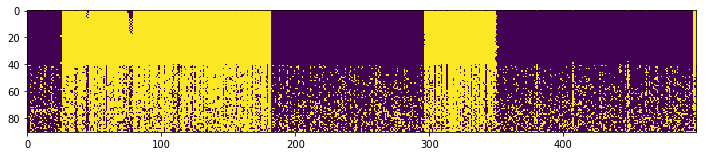

In [10]:
a = np.array(ex1.labels)
plt.figure(figsize = (12,4))
plt.imshow(a)

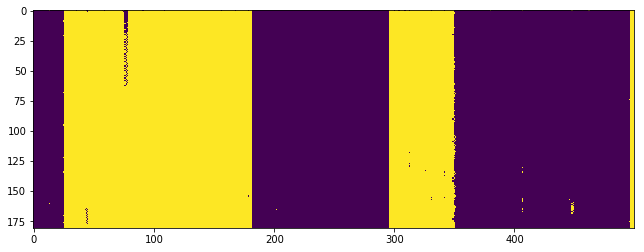

In [21]:
a = np.array(ex1.labels)
plt.figure(figsize = (12,4))
plt.imshow(a)

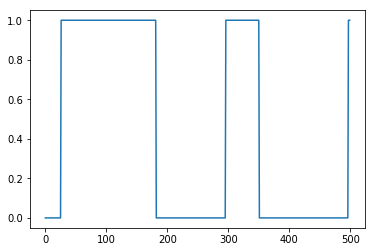

In [10]:
plt.plot(latent_1D)

In [19]:
np.min(ex1.betas)

-0.062759767662367461

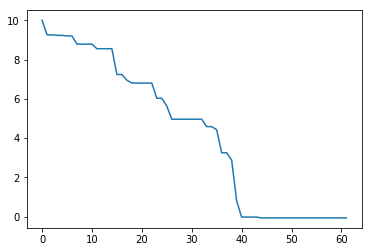

In [11]:
plt.plot(ex1.betas)

In [8]:
n = 10
models = [hmrf_gmm.HMRFGMM(phys_space, obs) for i in range(n)]

i = 30
for model in models:
    model.fit(i)

 50%|███████████████████████████████████████▌                                       | 15/30 [00:19<00:19,  1.29s/it]..\hmrf_gmm\hmrf_gmm_f.py:475: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(-te/t).T / np.sum(np.exp(-te/t), axis=1)).T
..\hmrf_gmm\hmrf_gmm_f.py:373: RuntimeWarning: divide by zero encountered in log
  lmd += (np.sum(np.log(storage2)))
..\hmrf_gmm\hmrf_gmm_f.py:230: RuntimeWarning: invalid value encountered in greater
  if (acc_ratio > 1) or (np.random.uniform() < acc_ratio):
 47%|████████████████████████████████████▊                                          | 14/30 [00:19<00:22,  1.41s/it]..\hmrf_gmm\hmrf_gmm_f.py:205: RuntimeWarning: invalid value encountered in true_divide
  acc_ratio = log_target_prop / log_target_prev
..\hmrf_gmm\hmrf_gmm_f.py:207: RuntimeWarning: invalid value encountered in greater
  if (acc_ratio > 1) or (np.random.uniform() < acc_ratio):
 73%|█████████████████████████████████████████████████████████▉                 

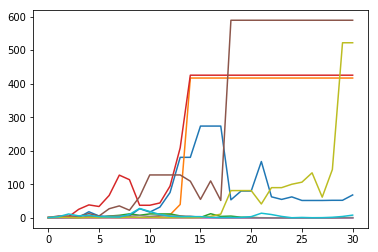

In [9]:
for model in models:
    plt.plot(model.betas)

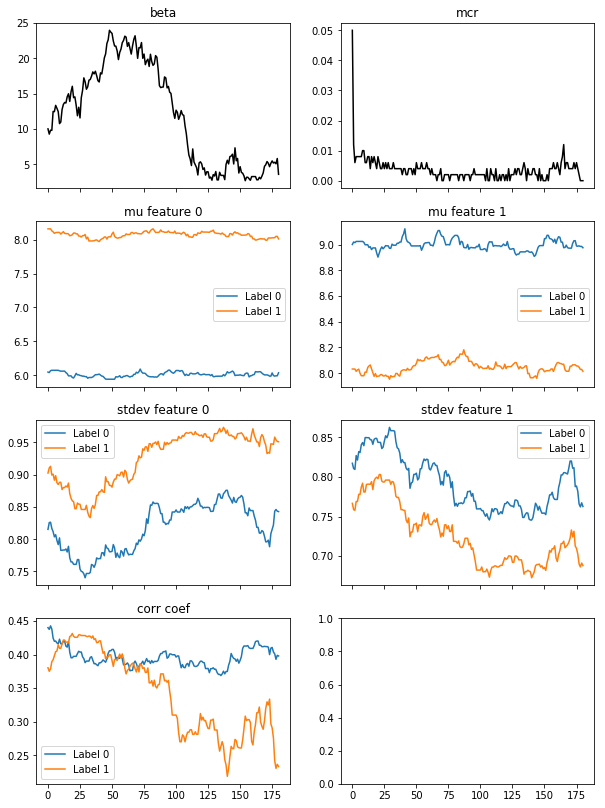

In [22]:
diagnostics(ex1, true_labels=latent_1D)

In [14]:
np.count_nonzero(ex1.labels[20] - latent_1D)

6

In [15]:
def mcr(self, true_labels):
    mcr_vals = []
    n = len(true_labels)  # TODO: 2d and 3d implementation for MCR
    for label in self.labels:
        missclassified = np.count_nonzero(true_labels - label)
        mcr_vals.append(missclassified / n)
    return mcr_vals

def get_std_from_cov(self, f, l):
    stds = []
    for i in range(len(self.covs)):
        stds.append(np.sqrt(np.diag(ex1.covs[i][l])[f]))
    return stds

def get_corr_coef_from_cov(self, l):
    corr_coefs = []
    for i in range(len(self.covs)):
        corr_coef = self.covs[i][l,0,1]
        for f in [0,1]:
            corr_coef = corr_coef / np.sqrt(np.diag(ex1.covs[i][l])[f])
        corr_coefs.append(corr_coef)
    return corr_coefs
    
def diagnostics(self, true_labels=None):
    fig, ax = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(10,14))
    
    ax[0,0].set_title("beta")
    ax[0,0].plot(self.betas, label="beta", color="black")
    
    if true_labels is not None:
        ax[0,1].set_title("mcr")
        ax[0,1].plot(mcr(ex1, latent_1D), label="mcr", color="black")

    for l in range(self.n_labels):
        ax[1,0].set_title("mu feature 0")
        ax[1,0].plot(np.array(self.mus)[:, :, 0][:, l], label="Label "+str(l))
        ax[1,0].legend()

        ax[1,1].set_title("mu feature 1")
        ax[1,1].plot(np.array(self.mus)[:, :, 1][:, l], label="Label "+str(l))
        ax[1,1].legend()
        
        ax[2,0].set_title("stdev feature 0")
        ax[2,0].plot(get_std_from_cov(self, 0, l), label="Label "+str(l))
        ax[2,0].legend()
        
        ax[2,1].set_title("stdev feature 1")
        ax[2,1].plot(get_std_from_cov(self, 1, l), label="Label "+str(l))
        ax[2,1].legend()
        
        ax[3,0].set_title("corr coef")
        ax[3,0].plot(get_corr_coef_from_cov(self, l), label="Label "+str(l))
        ax[3,0].legend()
        
        


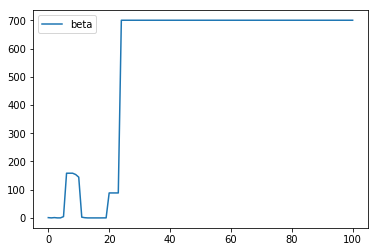

In [29]:
ax = plt.plot(ex1.betas, label="beta")
plt.legend()

In [11]:
ex1.labels[20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1,

Text(0.5,1,'a')

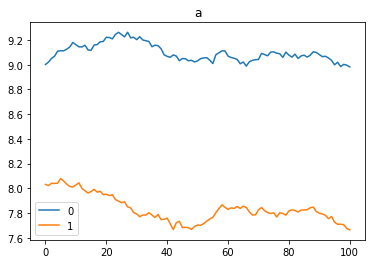

In [115]:
for l in [0,1]:
    ax = plt.plot(np.array(ex1.mus)[:,:,1][:,l], label=str(l))
plt.legend()
plt.title("a")

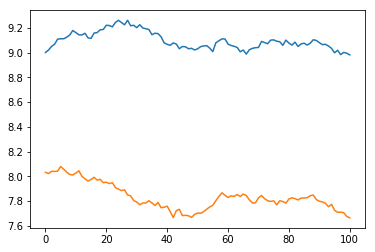

In [94]:
plt.plot(np.array(ex1.mus)[:,:,1])

In [ ]:
ax = plt.plot()

In [13]:
np.max(ex1.betas)

3.6697910773774804

In [21]:
ex1.mus[12]

array([[ 5.90263117,  9.14345733],
       [ 8.25592326,  7.99963641]])

In [24]:
ex1.mus[12][:,0]

array([ 5.90263117,  8.25592326])

In [22]:
plt.plot(ex1.mus[:][:,0])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
fig, ax = plt.subplots(nrows=)

In [16]:
np.mean(ex1.mus[50:])

7.7722543961918928

In [25]:
ex1.covs[12]

array([[[ 0.68062596,  0.29726327],
        [ 0.29726327,  0.63665378]],

       [[ 0.82445571,  0.24944777],
        [ 0.24944777,  0.56026519]]])